In [3]:
import pandas as pd
import numpy as np
# Load data (ensure files are uploaded to Colab)
train_df = pd.read_csv('train_karnataka.csv')
test_df = pd.read_csv('test_karnataka.csv')

# Preprocess
for df in [train_df, test_df]:
    df.rename(columns={'output': 'GDDP'}, inplace=True, errors='ignore')
    df.drop(df[df['district_name'] == 'CHAMRAJNAGAR'].index, inplace=True)

features = ['NTL_Sum', 'NTL_Mean', 'Population', 'Urbanisation',
            'Urban_Population', 'Rural_Population', 'pm25_min',
            'pm25_max', 'pm25_mean', 'pm25_num_cells']

In [4]:
def create_test_sequences(train_data, test_data, n_steps=3):
    X_test, y_test = [], []
    for district in test_data['district_name'].unique():
        # Get last n_steps years from TRAIN data
        train_subset = train_data[train_data['district_name'] == district].sort_values('year')
        if len(train_subset) >= n_steps:
            seq_features = train_subset[features].values[-n_steps:]
            # Get corresponding TEST year target
            test_subset = test_data[test_data['district_name'] == district]
            if not test_subset.empty:
                X_test.append(seq_features)
                y_test.append(test_subset['GDDP'].values[0])
    return np.array(X_test), np.array(y_test)

n_steps = 3
X_test_seq, y_test_seq = create_test_sequences(train_df, test_df, n_steps)

In [6]:
# For each district, create time window sequences
def create_sequences(data, n_steps=3):
    X, y = [], []
    for district in data['district_name'].unique():
        district_data = data[data['district_name'] == district].sort_values('year')
        for i in range(len(district_data) - n_steps):
            X.append(district_data[features].values[i:i+n_steps])
            y.append(district_data['GDDP'].values[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 3  # Use 3 years to predict the 4th
X_train_seq, y_train_seq = create_sequences(train_df, n_steps)

In [7]:
print("Train:", X_train_seq.shape, y_train_seq.shape)
print("Test:", X_test_seq.shape, y_test_seq.shape)

Train: (58, 3, 10) (58,)
Test: (29, 3, 10) (29,)


In [10]:
# Install required packages
!pip install tensorflow scikit-learn

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define parameters
n_steps = 3  # Number of timesteps in input sequence
features = ['NTL_Sum', 'NTL_Mean', 'Population', 'Urbanisation',
            'Urban_Population', 'Rural_Population', 'pm25_min',
            'pm25_max', 'pm25_mean', 'pm25_num_cells']

# Rebuild and train model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps, len(features)), return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train_seq, y_train_seq, epochs=200, verbose=1)

# Predict
test_pred = model.predict(X_test_seq)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_seq, test_pred))
r2 = r2_score(y_test_seq, test_pred)

# Print results
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 83319454695424.0000
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 106739374489600.0000
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 82518057418752.0000
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 82057891938304.0000
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105957287788544.0000
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 82795183472640.0000
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 80777211543552.0000
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 82389124513792.0000
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 81765624446976.0000
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 80385882980352.0000
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 80171965087744.0000
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 103404063948800.0000
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss:

In [11]:
import pandas as pd
import numpy as np

# Load test data (upload test_karnataka.csv first)
test_df = pd.read_csv('test_karnataka.csv')
test_df = test_df[test_df['district_name'] != 'CHAMRAJNAGAR']
test_df = test_df.rename(columns={'output': 'GDDP'})

In [12]:
test_df['Predicted_GDDP'] = np.nan  # Initialize column

# Match predictions to districts in test_df
pred_counter = 0
for i, district in enumerate(test_df['district_name']):
    if pred_counter < len(test_pred):
        test_df.loc[test_df.index[i], 'Predicted_GDDP'] = test_pred[pred_counter][0]
        pred_counter += 1

In [13]:
test_df['Predicted_GDDP'] = test_pred.flatten()

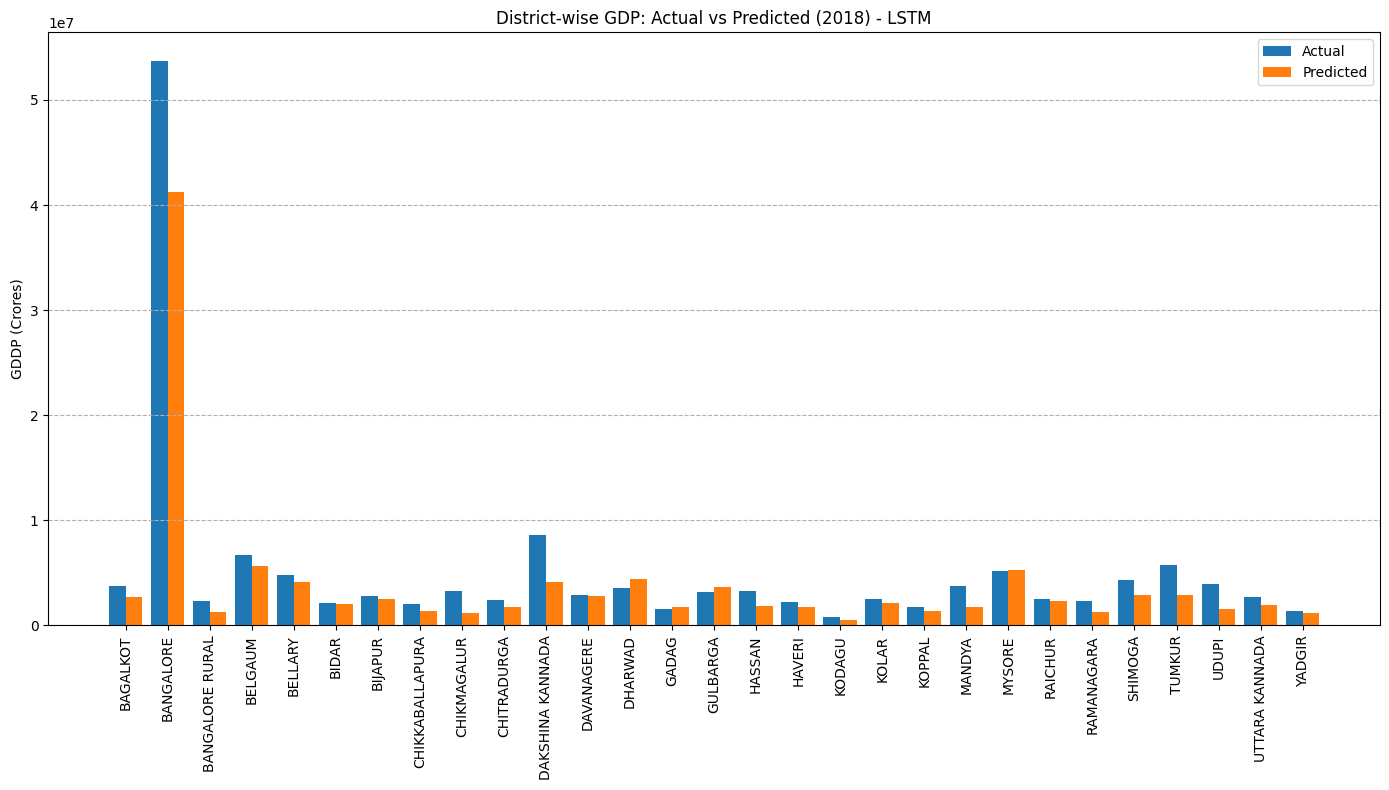

In [14]:
import matplotlib.pyplot as plt

# Create results DataFrame
results = test_df[['district_name', 'year', 'GDDP', 'Predicted_GDDP']].dropna()
results = results.rename(columns={'GDDP': 'Actual_GDDP'})

# Plot actual vs predicted
plt.figure(figsize=(14, 8))
results_sorted = results.sort_values('district_name')
x = np.arange(len(results_sorted))

plt.bar(x - 0.2, results_sorted['Actual_GDDP'], width=0.4, label='Actual', color='#1f77b4')
plt.bar(x + 0.2, results_sorted['Predicted_GDDP'], width=0.4, label='Predicted', color='#ff7f0e')

plt.xticks(x, results_sorted['district_name'], rotation=90)
plt.ylabel('GDDP (Crores)')
plt.title('District-wise GDP: Actual vs Predicted (2018) - LSTM')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

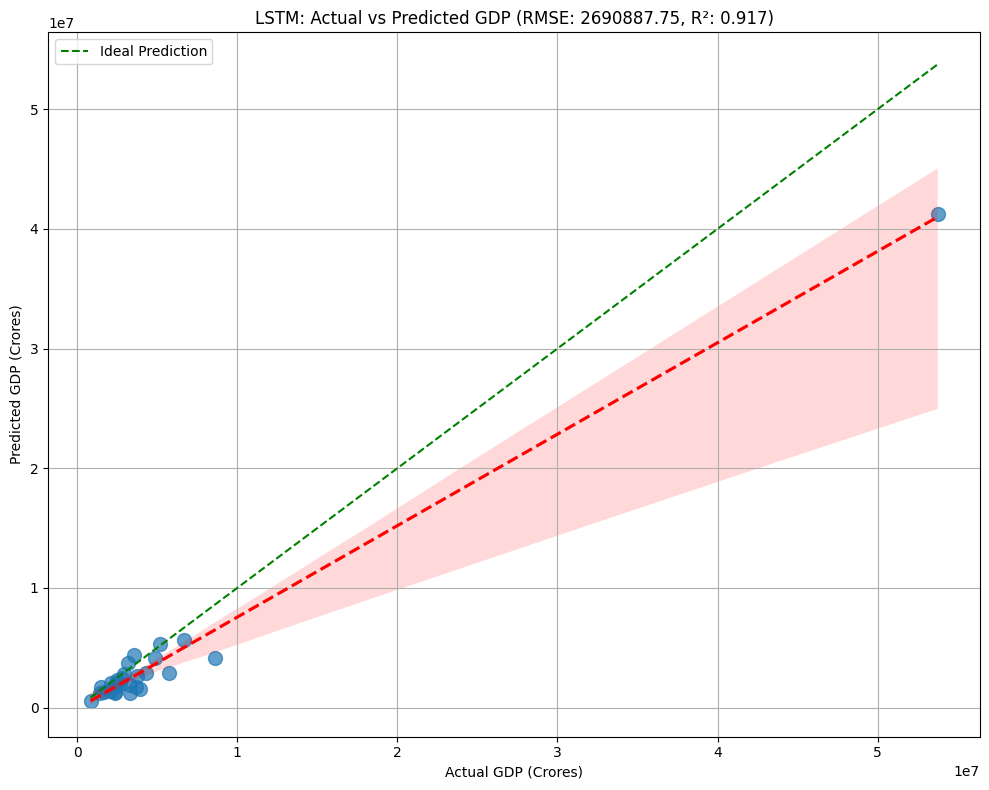

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure test_df has predictions
test_df['Predicted_GDDP'] = np.nan  # Initialize column

# Map predictions to test_df (accounts for possible sequence filtering)
pred_counter = 0
for district in test_df['district_name']:
    district_in_test_seq = district in np.unique(test_df['district_name'][:len(test_pred)])
    if pred_counter < len(test_pred) and district_in_test_seq:
        test_df.loc[test_df['district_name'] == district, 'Predicted_GDDP'] = test_pred[pred_counter][0]
        pred_counter += 1

# Create results DataFrame
results = test_df[['district_name', 'GDDP', 'Predicted_GDDP']].dropna()
results = results.rename(columns={'GDDP': 'Actual_GDDP'})

# Plot
plt.figure(figsize=(10, 8))
sns.regplot(x='Actual_GDDP', y='Predicted_GDDP', data=results,
            scatter_kws={'s': 100, 'alpha': 0.7, 'color': '#1f77b4'},
            line_kws={'color': 'red', 'linestyle': '--'})

# Perfect prediction line
plt.plot([results['Actual_GDDP'].min(), results['Actual_GDDP'].max()],
         [results['Actual_GDDP'].min(), results['Actual_GDDP'].max()],
         'g--', label='Ideal Prediction')

# Calculate metrics
rmse = np.sqrt(mean_squared_error(results['Actual_GDDP'], results['Predicted_GDDP']))
r2 = r2_score(results['Actual_GDDP'], results['Predicted_GDDP'])

plt.title(f'LSTM: Actual vs Predicted GDP (RMSE: {rmse:.2f}, R²: {r2:.3f})')
plt.xlabel('Actual GDP (Crores)')
plt.ylabel('Predicted GDP (Crores)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

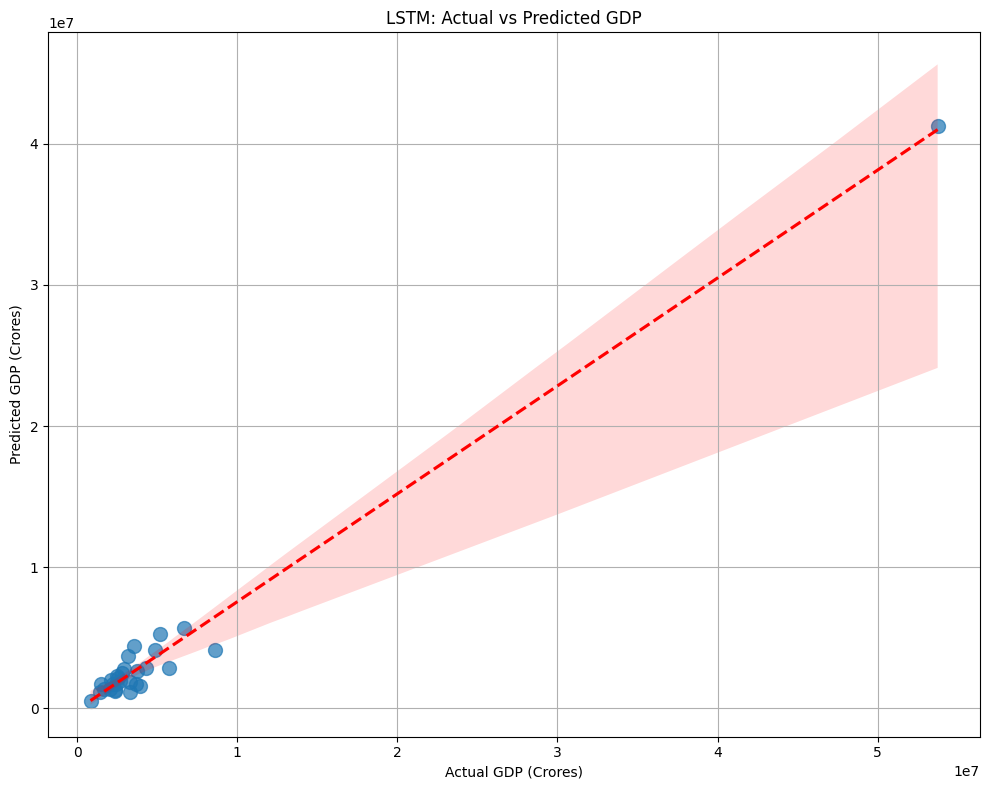

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.regplot(x='Actual_GDDP', y='Predicted_GDDP', data=results,
            scatter_kws={'s': 100, 'alpha': 0.7, 'color': '#1f77b4'},
            line_kws={'color': 'red', 'linestyle': '--'})

plt.title('LSTM: Actual vs Predicted GDP')
plt.xlabel('Actual GDP (Crores)')
plt.ylabel('Predicted GDP (Crores)')
plt.grid(True)
plt.tight_layout()
plt.show()

Baseline RMSE: 2690887.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


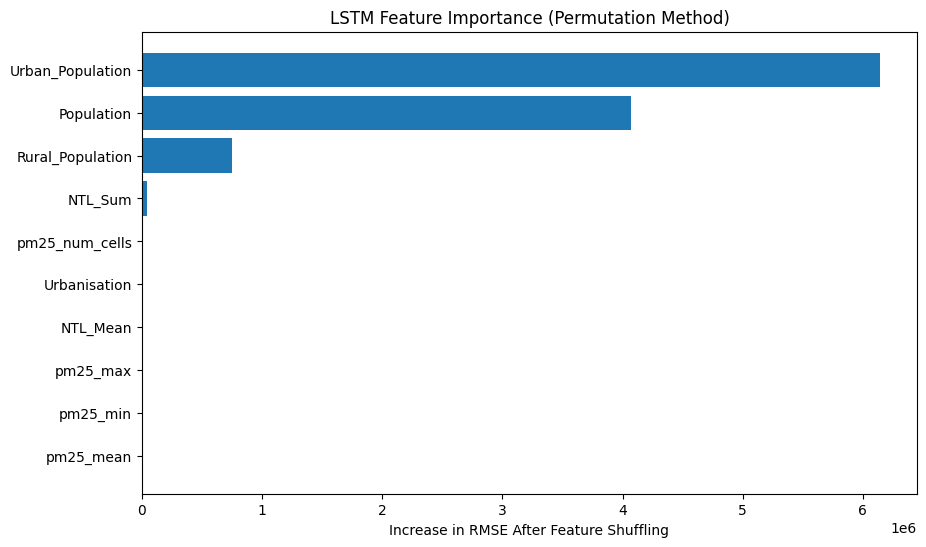

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define baseline performance
baseline_rmse = np.sqrt(mean_squared_error(y_test_seq, test_pred))
print(f"Baseline RMSE: {baseline_rmse:.2f}")

# 2. Initialize importance storage
feature_importances = np.zeros(len(features))

# 3. Iterate through features
for feature_idx in range(len(features)):
    # Create perturbed test data
    X_test_perturbed = X_test_seq.copy()

    # Perturb the feature across all time steps
    X_test_perturbed[:, :, feature_idx] = np.random.permutation(X_test_perturbed[:, :, feature_idx])

    # Predict with perturbed data
    perturbed_pred = model.predict(X_test_perturbed)
    perturbed_rmse = np.sqrt(mean_squared_error(y_test_seq, perturbed_pred))

    # Calculate importance
    feature_importances[feature_idx] = perturbed_rmse - baseline_rmse

# 4. Plot results
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title("LSTM Feature Importance (Permutation Method)")
plt.xlabel("Increase in RMSE After Feature Shuffling")
plt.show()

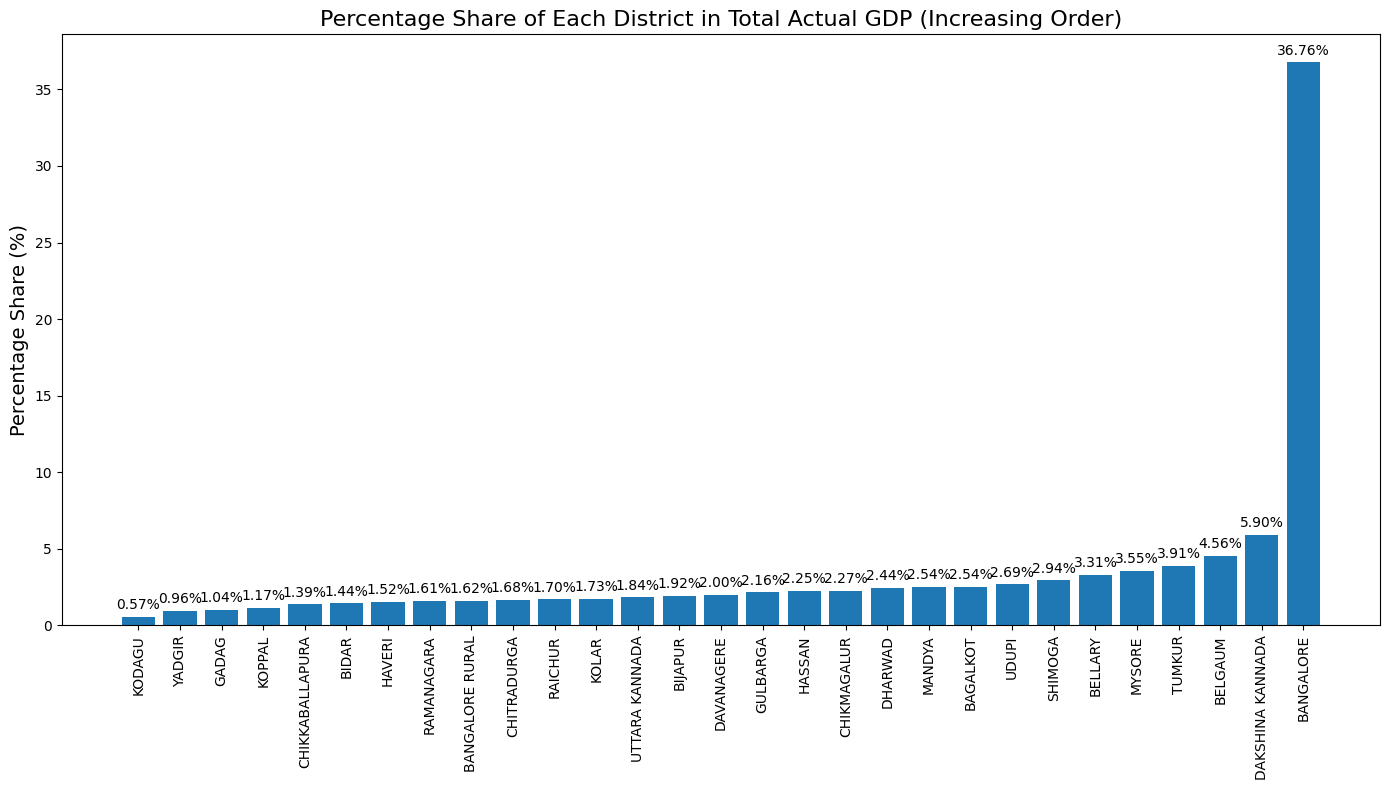

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure test_df is loaded and preprocessed with 'district_name' and 'GDDP' columns
# test_df = pd.read_csv('test_karnataka.csv')
# test_df = test_df[test_df['district_name'] != 'CHAMRAJNAGAR']
# test_df = test_df.rename(columns={'output': 'GDDP'})

# Calculate total GDP
actual_total = test_df['GDDP'].sum()

# Calculate percentage share by district
actual_shares = test_df.groupby('district_name')['GDDP'].sum() / actual_total * 100

# Sort by percentage share in increasing order
actual_shares_sorted = actual_shares.sort_values()

# Plot bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(actual_shares_sorted.index, actual_shares_sorted.values, color='#1f77b4')
plt.title('Percentage Share of Each District in Total Actual GDP (Increasing Order)', fontsize=16)
plt.ylabel('Percentage Share (%)', fontsize=14)
plt.xticks(rotation=90)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

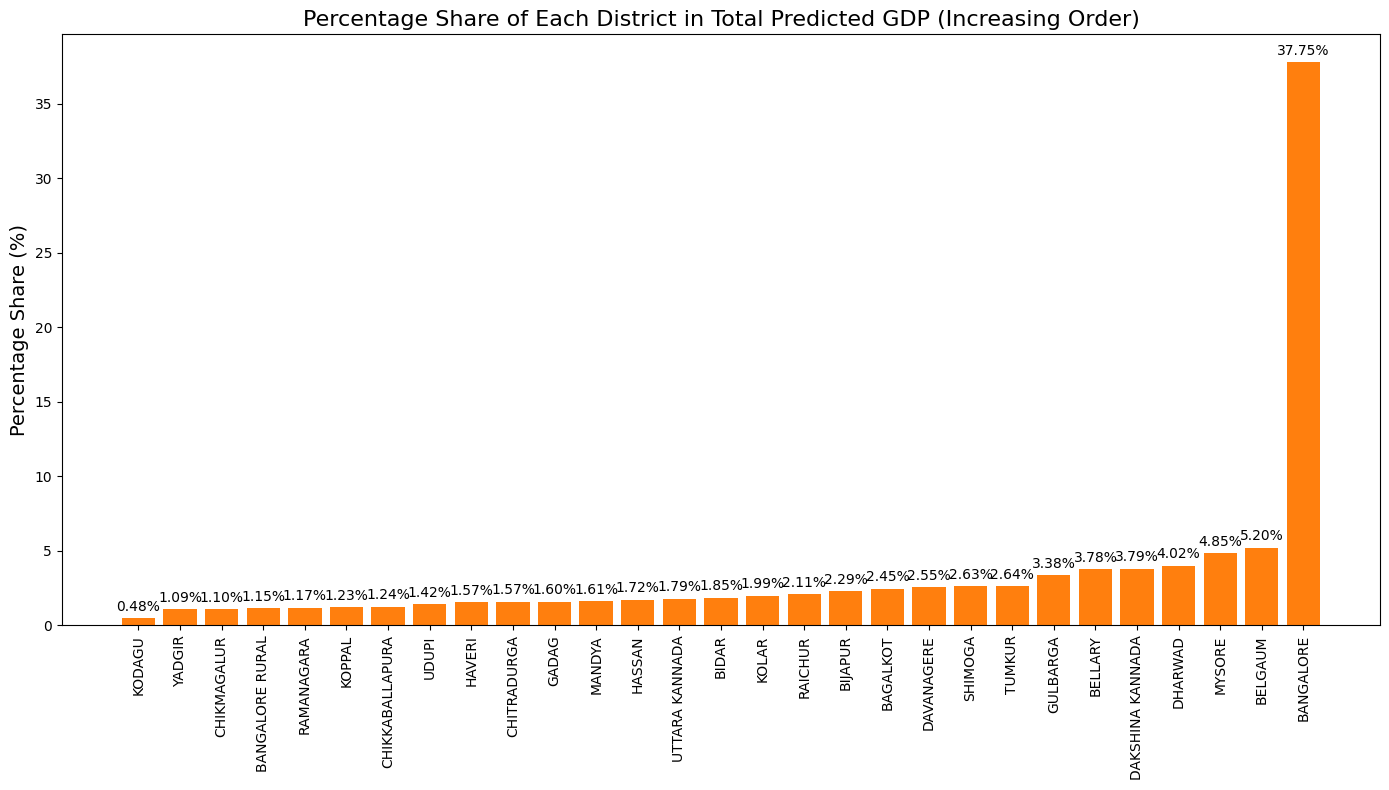

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure test_df is available and contains 'district_name' and 'Predicted_GDDP' columns
# If you need to load the data:
# test_df = pd.read_csv('test_karnataka.csv')
# test_df = test_df[test_df['district_name'] != 'CHAMRAJNAGAR']
# test_df = test_df.rename(columns={'output': 'GDDP'})
# test_df['Predicted_GDDP'] = ...  # Your LSTM or XGBoost predictions

# Calculate total predicted GDP
predicted_total = test_df['Predicted_GDDP'].sum()

# Calculate percentage share by district for predicted GDP
predicted_shares = test_df.groupby('district_name')['Predicted_GDDP'].sum() / predicted_total * 100

# Sort by percentage share in increasing order
predicted_shares_sorted = predicted_shares.sort_values()

# Plot bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(predicted_shares_sorted.index, predicted_shares_sorted.values, color='#ff7f0e')
plt.title('Percentage Share of Each District in Total Predicted GDP (Increasing Order)', fontsize=16)
plt.ylabel('Percentage Share (%)', fontsize=14)
plt.xticks(rotation=90)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
import numpy as np

# Assuming test_df is loaded and contains:
# 'district_name', 'GDDP', 'Predicted_GDDP'
# If not, load and preprocess as before:
# test_df = pd.read_csv('test_karnataka.csv')
# test_df = test_df[test_df['district_name'] != 'CHAMRAJNAGAR']
# test_df = test_df.rename(columns={'output': 'GDDP'})
# test_df['Predicted_GDDP'] = ...  # Your model predictions

# Calculate percentage error
test_df['Percentage_Error'] = np.abs((test_df['GDDP'] - test_df['Predicted_GDDP']) / test_df['GDDP']) * 100

# Rename columns for clarity
results = test_df[['district_name', 'GDDP', 'Predicted_GDDP', 'Percentage_Error']]
results = results.rename(columns={'GDDP': 'Actual_GDDP'})

# Save to CSV
results.to_csv('district_gddp_predictions_with_error.csv', index=False)

# Optional: Print sample output
print(results.head())

     district_name  Actual_GDDP  Predicted_GDDP  Percentage_Error
0         BAGALKOT      3711497    2.678024e+06         27.845193
1        BANGALORE     53745884    4.127377e+07         23.205714
2  BANGALORE RURAL      2368917    1.253223e+06         47.097223
3          BELGAUM      6669748    5.689535e+06         14.696402
4          BELLARY      4841015    4.136033e+06         14.562695
